## Imports

In [1]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

C:\Users\parik\AppData\Local\Temp\ipykernel_14472\1267553452.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


## Get filenames

In [2]:
# Get files in data path
path='./audio/london_phill_dataset_multi/'
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 700 audio files in ./audio/london_phill_dataset_multi/


## Prepare labels from filenames

In [4]:
# Get Labels
labels =[]
classes=['cello', 'flute', 'guitar', 'oboe', 'sax', 'trumpet', 'viola']
color_dict={'cello':'blue', 'flute':'red', 'guitar':'orange','oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [5]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

7 classes: cello, flute, guitar, oboe, sax, trumpet, viola


## Parameters for MFCC

In [6]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Function to Calculate Audio Features: MFCC

In [7]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
"""def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector"""

In [15]:
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfccs,1)
    feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector



## Load audio files, calculate features and create feature vectors

In [16]:
# Load audio files, calculate features and create feature vectors
"""feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))""" 
# Load audio files, calculate features and create feature vectors
feature_vectors = []
for i, f in enumerate(files):
    print("get %d of %d = %s" % (i + 1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y /= y.max()  # Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        mfccs = get_features(y, sr)
        feature_vectors.append(mfccs)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f, e))

print("Calculated %d feature vectors" % len(feature_vectors))


get 1 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_forte_arco-normal.mp3
get 2 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_fortissimo_arco-normal.mp3
get 3 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
get 4 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_mezzo-piano_arco-normal.mp3
get 5 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_025_pianissimo_arco-normal.mp3
get 6 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_05_forte_arco-normal.mp3
get 7 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_05_fortissimo_arco-normal.mp3
get 8 of 700 = ./audio/london_phill_dataset_multi/london_phill_dataset_multi\cello\cello_A2_05_mezzo-piano_arco-normal.mp3
get 9 of 700 = 

## Standardization: Zero-Mean and Unit-Variance

In [17]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (700, 13)


## Train and Test Sets

In [18]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [19]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (525, 13)
test_set shape: (175, 13)
train_classes shape: (525,)
test_classes shape: (175,)


## kNN Classification

In [20]:
# KNN Classifier
n_neighbors=1
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [21]:
# kNN
model_knn.fit(train_set, train_classes);

In [22]:
# Predict using the Test Set
predicted_labels = model_knn.predict(test_set)

## Evaluation

In [23]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.92 0.88 0.92 1.   0.88 0.96 0.92]
Precision:  [0.92       0.88       0.95833333 0.96153846 0.95652174 0.96
 0.85185185]
F1-Score:  [0.92       0.88       0.93877551 0.98039216 0.91666667 0.96
 0.88461538]
Accuracy: 0.93  , 162
Number of samples: 175


In [24]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [25]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

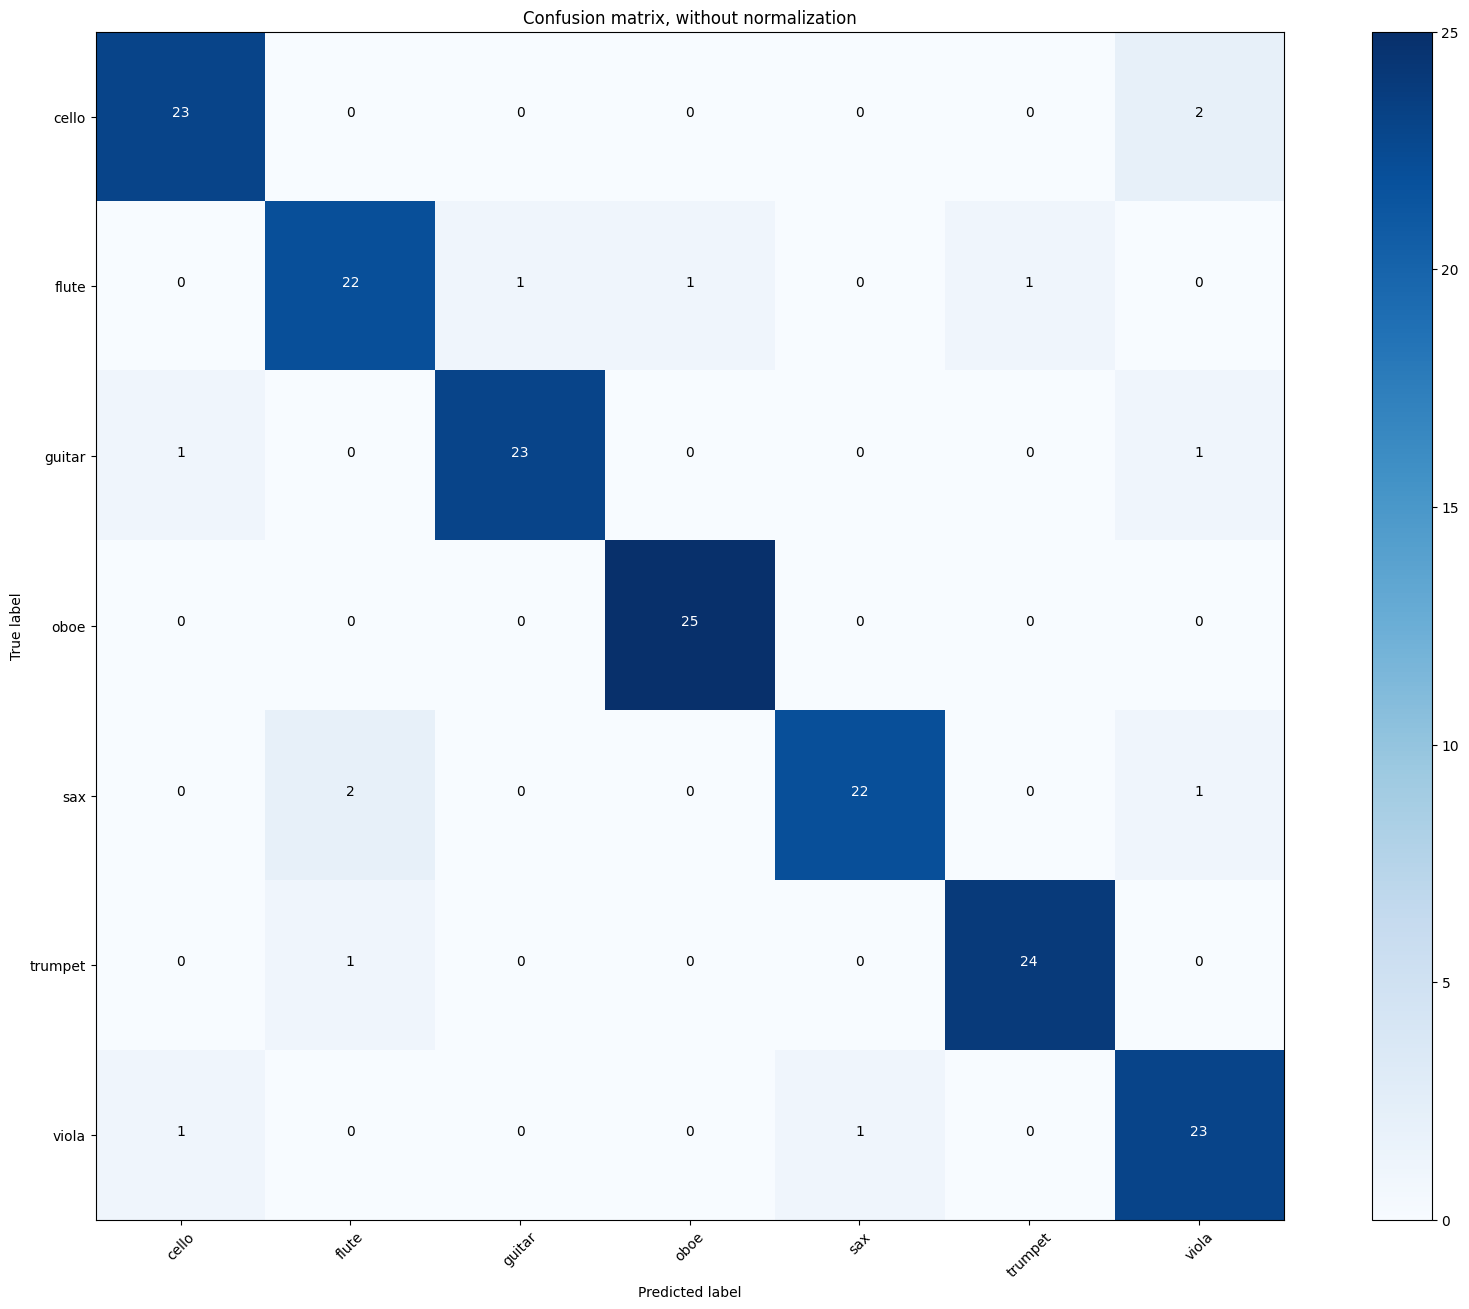

In [26]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [27]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [28]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['viola' 'flute' 'sax' 'flute' 'sax' 'flute' 'cello' 'trumpet' 'viola'
 'guitar' 'guitar' 'sax' 'cello']
[0 2 6 5 1 3 6 1 4 0 6 1 6]
['cello' 'guitar' 'viola' 'trumpet' 'flute' 'oboe' 'viola' 'flute' 'sax'
 'cello' 'viola' 'flute' 'viola']
['./audio/london_phill_dataset_multi/london_phill_dataset_multi\\viola\\viola_A4_05_fortissimo_arco-normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\flute\\flute_A4_025_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\sax\\saxophone_Ds4_05_piano_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\flute\\flute_A5_025_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\sax\\saxophone_Ds5_1_forte_major-trill.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\flute\\flute_Gs5_05_pianissimo_normal.mp3'
 './audio/london_phill_dataset_multi/london_phill_dataset_multi\\cello\\cello_Gs5_025_forte_arco-normal.mp3'
 